# [OSMsc](https://github.com/ruirzma/osmsc) Denver case study

Author: [Rui Ma](https://github.com/ruirzma)

Taking Denver as an example, this notebook demonstrates the entire working process of OSMsc.

In [4]:
import osmnx as ox
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import osmsc as oc

In [5]:
oc.__package__

'osmsc'

In [6]:
cityName = "Denver"

bbox_Denver = (39.7800, -105.0344, 39.7854, -105.0194) # only for test

In [7]:
BG = oc.building_group(bbox= bbox_Denver)
building_gdf = BG.get_gdf()

In [8]:
building_gdf.head(2)

,osmid,geometry,tags,osmscID,Building_area,Building_perimeter
0,255324702,"POLYGON ((-105.02708 39.78344, -105.02708 39.7...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324702,2599.300448,466.833829
1,255324705,"POLYGON ((-105.02574 39.78338, -105.02574 39.7...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324705,472.878887,94.318348


In [9]:
building_gdf_prj = ox.project_gdf(building_gdf)

In [10]:
VG = oc.vegetation_group(bbox = bbox_Denver)
VG_gdf = VG.get_gdf()
VG_gdf_prj = ox.project_gdf(VG_gdf)

In [11]:
WG = oc.waterbody_group(bbox = bbox_Denver)
WG_gdf = WG.get_gdf()
WG_gdf_prj = ox.project_gdf(WG_gdf)

In [12]:
SG = oc.transportation_group( bbox= bbox_Denver, trans_type= ['primary','secondary', 'tertiary','residential','motorway','motorway_link'])

street_gdf_prj = SG.get_gdf_prj()

In [13]:
UG = oc.urban_patch_group(bbox= bbox_Denver, trans_type= ['primary','secondary', 'tertiary'
                                                                   ,'residential','motorway','motorway_link'])
urban_patch_gdf_prj = UG.get_gdf_prj()

In [14]:
urban_patch_gdf_prj.head(2)

,geometry,osmscID,UrbanPatch_area,UrbanPatch_perimeter
0,"POLYGON ((497040.429 4403575.532, 497040.940 4...",UrbanPatch_0,268117.620188,2442.500354
1,"POLYGON ((497743.053 4403577.969, 497744.741 4...",UrbanPatch_1,18224.654767,588.552825


[]

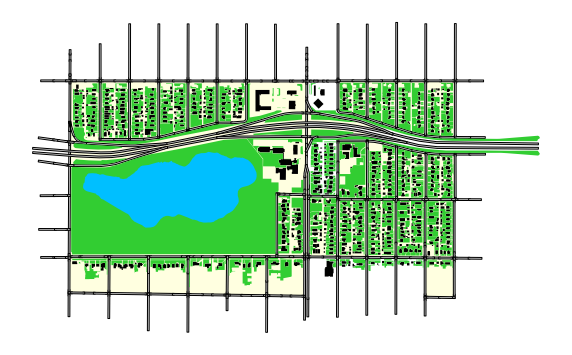

In [15]:
ax = urban_patch_gdf_prj.plot(figsize=(10, 10), edgecolor='white',linewidth=0.5, facecolor = "lightyellow")
building_gdf_prj.plot(ax=ax , color='k')
street_gdf_prj.plot(ax=ax, edgecolor='k',linewidth=1, facecolor = "lightgray")
VG_gdf_prj.plot(ax=ax , color = "limegreen")
WG_gdf_prj.plot(ax=ax , color = "deepskyblue")
ax.patch.set_facecolor("None")
ax.set_xticks([])
ax.set_yticks([])

In [13]:
json_path = "data/_Case_Denver.geojson"
externalBuilding_gdf = gpd.GeoDataFrame.from_file(json_path)
externalBuilding_gdf.crs = "epsg:4326"
externalBuilding_gdf_prj = ox.project_gdf(externalBuilding_gdf)

externalBuilding_gdf.head(2)

,CREATEDATE,CREATEUSER,BUILDING_I,BLDG_HEIGH,GROUND_ELE,BLDG_TYPE,SOURCE,COMMENTS,UPDATE_STA,geometry
0,2015-10-09,Kucera,294572,16,5357,Residential,Visual,None,M,"MULTIPOLYGON (((-105.01844 39.78846, -105.0183..."
1,2015-10-09,Kucera,294894,18,5351,Residential,Visual,None,N,"MULTIPOLYGON (((-105.01798 39.78853, -105.0179..."


## fuse building height

In [14]:
building_gdf_prj = oc.fusion.add_building_height(building_gdf_prj, externalBuilding_gdf_prj, extColName = "BLDG_HEIGH" )
#building_gdf_prj["Building_height"] = building_gdf_prj[["Building_height"]].fillna(1) # 防止可视化不清楚

Please wait a few minutes


In [15]:
max(list(building_gdf_prj["Building_height"])), min(list(building_gdf_prj["Building_height"]))

(45.0, 1.0)

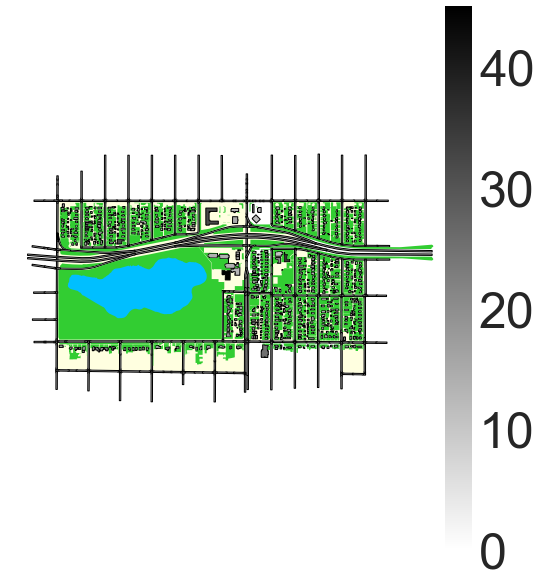

In [16]:
ax = urban_patch_gdf_prj.plot(figsize=(10, 10), edgecolor='white',linewidth=1, facecolor = "lightyellow")
building_gdf_prj.plot(ax = ax, edgecolor='k',
                                 linewidth=1,
                                 column="Building_height",
                                 cmap='binary',legend= True,vmin=0, vmax=45)

street_gdf_prj.plot(ax=ax, edgecolor='k',linewidth=1, facecolor = "lightgray")
VG_gdf_prj.plot(ax=ax , color = "limegreen")
WG_gdf_prj.plot(ax=ax , color = "deepskyblue")


fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.65, 0.5))

ax.set_axis_off()

In [ ]:
urban_patch_gdf_prj = oc.fusion.add_elevation(urban_patch_gdf_prj, elevation_dataset = "aster30m")

In [18]:
urban_patch_gdf_prj.head(2)

,geometry,osmscID,UrbanPatch_area,UrbanPatch_perimeter,elevation
0,"POLYGON ((497040.429 4403575.532, 497040.940 4...",UrbanPatch_0,268117.620188,2442.500354,"[{'lat': 39.78029132732065, 'lon': -105.030373..."
1,"POLYGON ((497743.053 4403577.969, 497744.741 4...",UrbanPatch_1,18224.654767,588.552825,"[{'lat': 39.78029253283681, 'lon': -105.025351..."


In [19]:
street_gdf_prj = oc.fusion.add_elevation(street_gdf_prj, elevation_dataset = "aster30m")

In [20]:
street_grid_gdf = oc.fusion.get_intersected_grid_gdf(street_gdf_prj, elevation_dataset = "aster30m")
street_grid_gdf_prj = ox.project_gdf(street_grid_gdf)

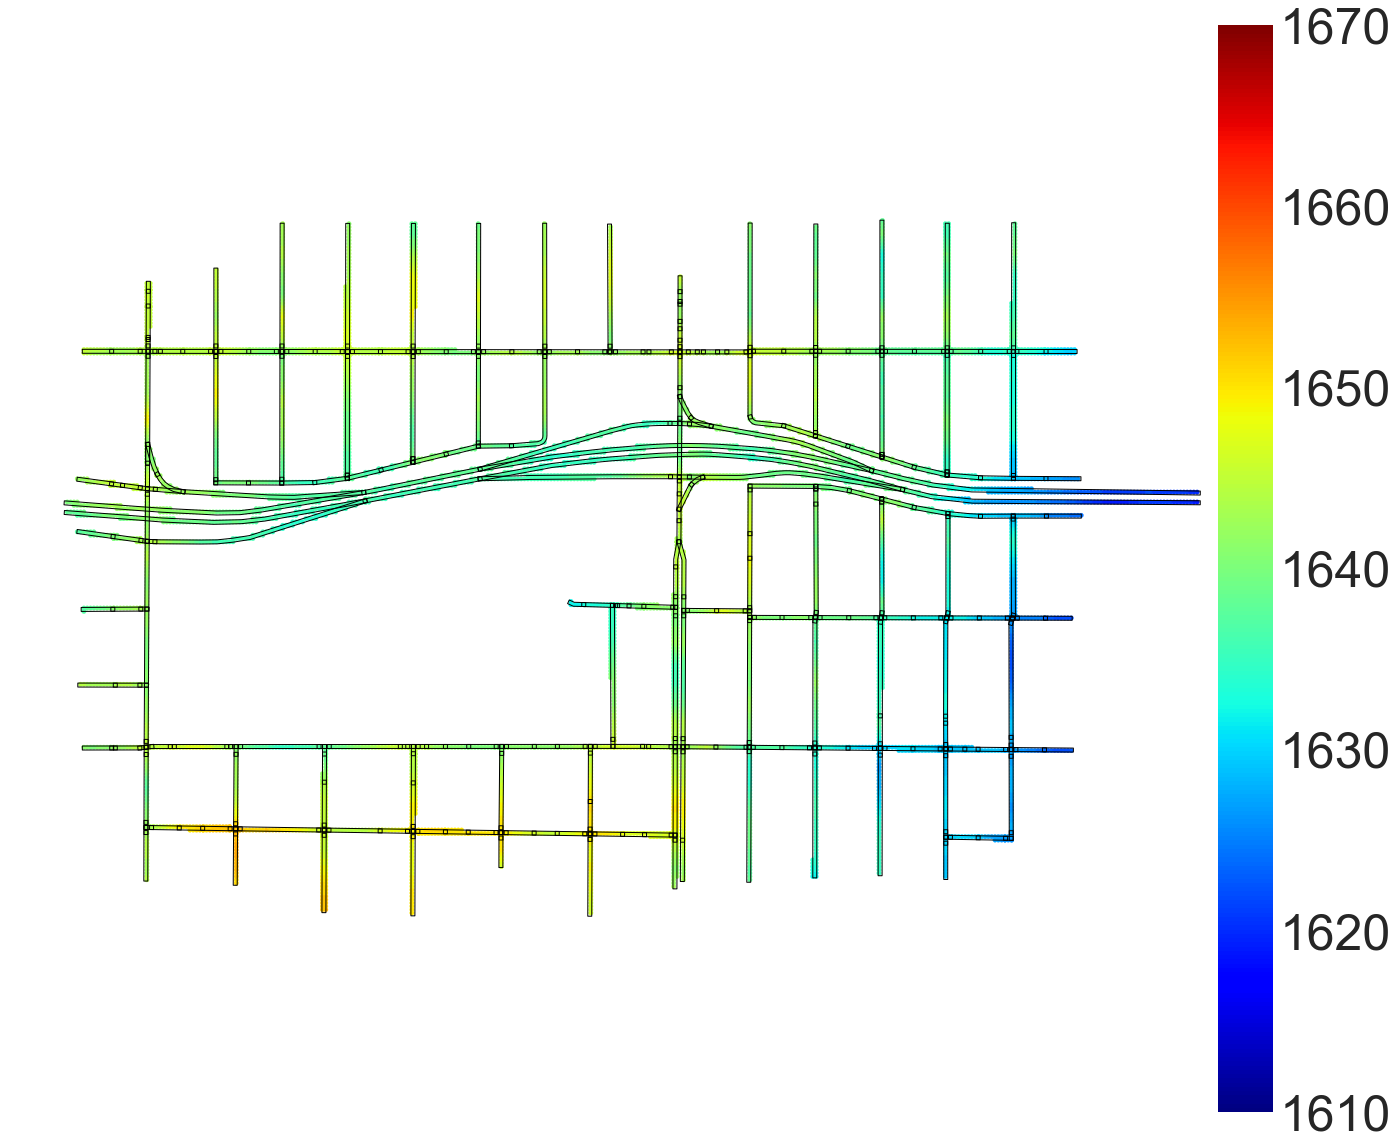

In [21]:
ax = street_grid_gdf_prj.plot(figsize=(28,20), column="ground_elevation", cmap='jet',legend = True, 
    
                               markersize = 20, vmin=1610, vmax=1670) # ,vmin=1635, vmax=1665

street_gdf_prj.plot(ax = ax, edgecolor='k',linewidth=1, facecolor = "None")


fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.65, 0.5))

ax.set_axis_off()


In [22]:
building_gdf_prj = oc.fusion.add_building_tags(OSMscBuilding_gdf = building_gdf_prj, 
                                          tagColName = "Building_use" ,
                                          externalBuilding_gdf = externalBuilding_gdf_prj, 
                                          extColName = "BLDG_TYPE")

In [23]:
building_gdf_prj.head(2)

,osmid,geometry,tags,osmscID,Building_area,Building_perimeter,Building_height,Building_use
0,255324702,"POLYGON ((497681.062 4403722.222, 497681.132 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324702,2599.300448,466.833829,13.909091,Commercial
1,255324705,"POLYGON ((497796.205 4403714.863, 497796.215 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324705,472.878887,94.318348,18.000000,Commercial


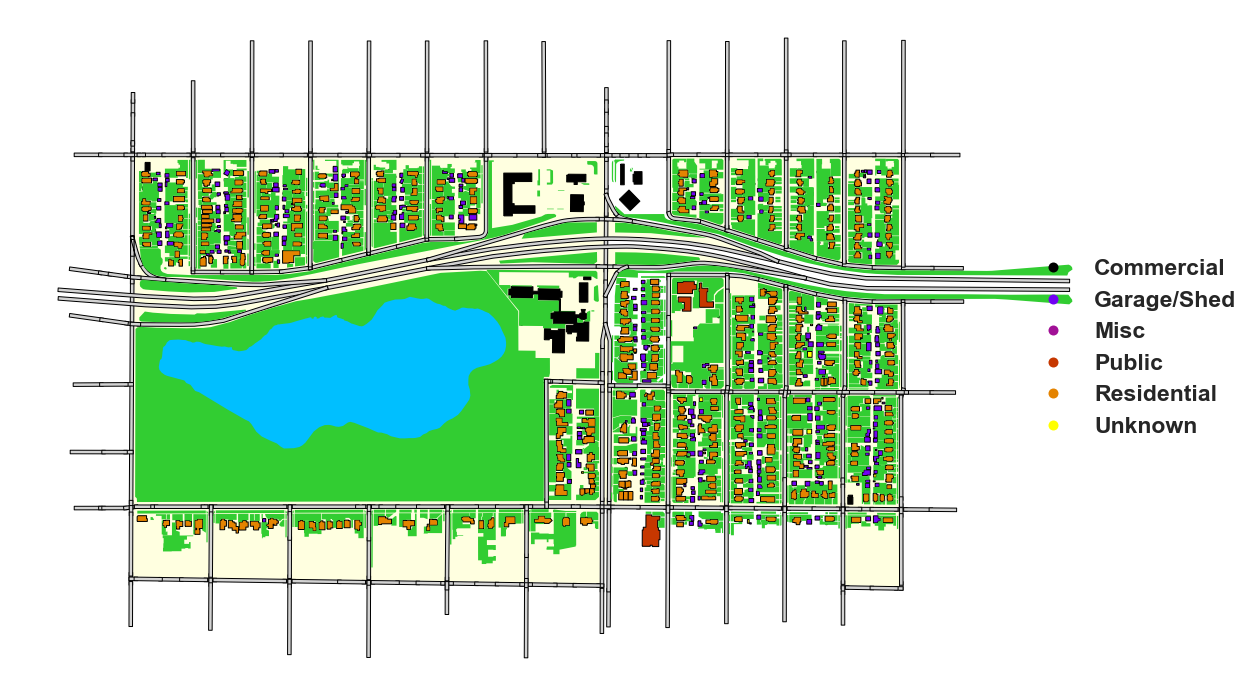

In [24]:
ax = urban_patch_gdf_prj.plot(figsize=(20, 20), edgecolor='white',linewidth=1, facecolor = "lightyellow")

building_gdf_prj.plot(ax = ax, edgecolor='k',linewidth=1,column="Building_use",cmap='gnuplot',
                                   legend= True,legend_kwds= {"loc":'right',"bbox_to_anchor":(1.12, 0.5), 
                                           "prop":{'size': 23, 'weight':'bold'}})

street_gdf_prj.plot(ax=ax, edgecolor='k',linewidth=1, facecolor = "lightgray")

VG_gdf_prj.plot(ax=ax , color = "limegreen")
WG_gdf_prj.plot(ax=ax , color = "deepskyblue")

ax.set_axis_off()

In [25]:
urban_patch_gdf_prj = oc.feature.add_spatial_semantics_attr(urban_patch_gdf_prj,building_gdf_prj,"contains_Building")
urban_patch_gdf_prj = oc.feature.add_spatial_semantics_attr(urban_patch_gdf_prj,VG_gdf_prj,"contains_Vegetation")
urban_patch_gdf_prj = oc.feature.add_spatial_semantics_attr(urban_patch_gdf_prj,WG_gdf_prj,"contains_Waterbody")

In [26]:
building_gdf_prj = oc.feature.add_spatial_semantics_attr(building_gdf_prj,urban_patch_gdf_prj,"within_UrbanPatch")
VG_gdf_prj = oc.feature.add_spatial_semantics_attr(VG_gdf_prj,urban_patch_gdf_prj,"within_UrbanPatch")
WG_gdf_prj = oc.feature.add_spatial_semantics_attr(WG_gdf_prj,urban_patch_gdf_prj,"within_UrbanPatch")

In [27]:
building_gdf_prj.head(2)

,osmid,geometry,tags,osmscID,Building_area,Building_perimeter,Building_height,Building_use,within_UrbanPatch
0,255324702,"POLYGON ((497681.062 4403722.222, 497681.132 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324702,2599.300448,466.833829,13.909091,Commercial,[UrbanPatch_0]
1,255324705,"POLYGON ((497796.205 4403714.863, 497796.215 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324705,472.878887,94.318348,18.000000,Commercial,[UrbanPatch_0]


In [28]:
VG_gdf_prj.head(2)

,osmid,geometry,tags,osmscID,Vegetation_area,Vegetation_perimeter,within_UrbanPatch
0,93548908,"POLYGON ((497191.589 4403458.539, 497202.584 4...","{'leisure': 'pitch', 'sport': 'tennis'}",Vegetation_93548908,261.776034,69.605939,[UrbanPatch_0]
1,231151082,"POLYGON ((497043.921 4403669.468, 497043.238 4...","{'ele': '1637', 'leisure': 'park', 'name': 'Ro...",Vegetation_231151082,233201.612756,2061.388411,[UrbanPatch_0]


In [29]:
WG_gdf_prj.head(2)

,osmid,geometry,tags,osmscID,Waterbody_area,Waterbody_perimeter,within_UrbanPatch
0,93548907,"POLYGON ((497097.157 4403646.684, 497095.554 4...","{'name': 'Rocky Mountain Lake', 'natural': 'wa...",WaterBody_93548907,91588.477213,1477.73809,[UrbanPatch_0]


# Geometrics

In [30]:
urban_patch_gdf_prj = oc.feature.add_minimum_rotated_rectangle_attr(urban_patch_gdf_prj)
urban_patch_gdf_prj = oc.feature.add_minimum_circumscribed_circle_attr(urban_patch_gdf_prj)
urban_patch_gdf_prj = oc.feature.add_polygon_bearing_attr(urban_patch_gdf_prj)
urban_patch_gdf_prj = oc.feature.add_shape_factor_attr(urban_patch_gdf_prj)

In [31]:
building_gdf_prj = oc.feature.add_polygon_bearing_attr(building_gdf_prj)

In [32]:
mrr_gdf = gpd.GeoDataFrame()
mrr_gdf["geometry"] = urban_patch_gdf_prj["mrr_geometry"]
mrr_gdf.crs = urban_patch_gdf_prj.crs

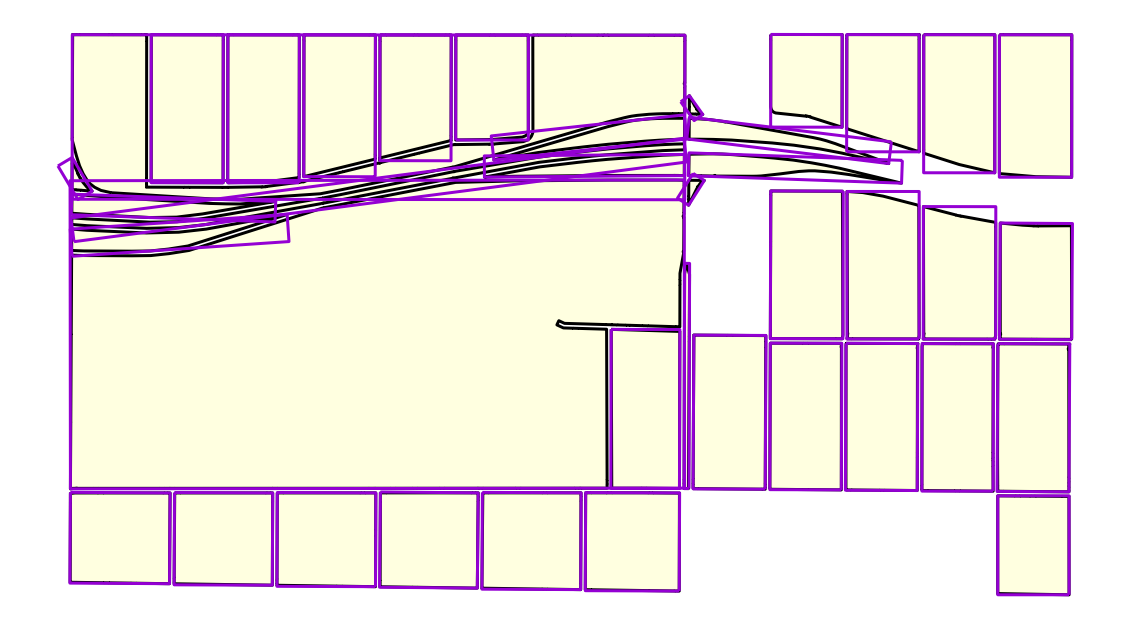

In [33]:
ax = urban_patch_gdf_prj.plot(figsize=(20, 20), edgecolor='k',linewidth=3, facecolor = "lightyellow")

mrr_gdf.plot(ax = ax, edgecolor='darkviolet',linewidth=3, facecolor = "None")
ax.set_axis_off()


In [34]:
mcc_gdf = gpd.GeoDataFrame()
mcc_gdf["geometry"] = urban_patch_gdf_prj["mcc_geometry"]
mcc_gdf.crs = urban_patch_gdf_prj.crs

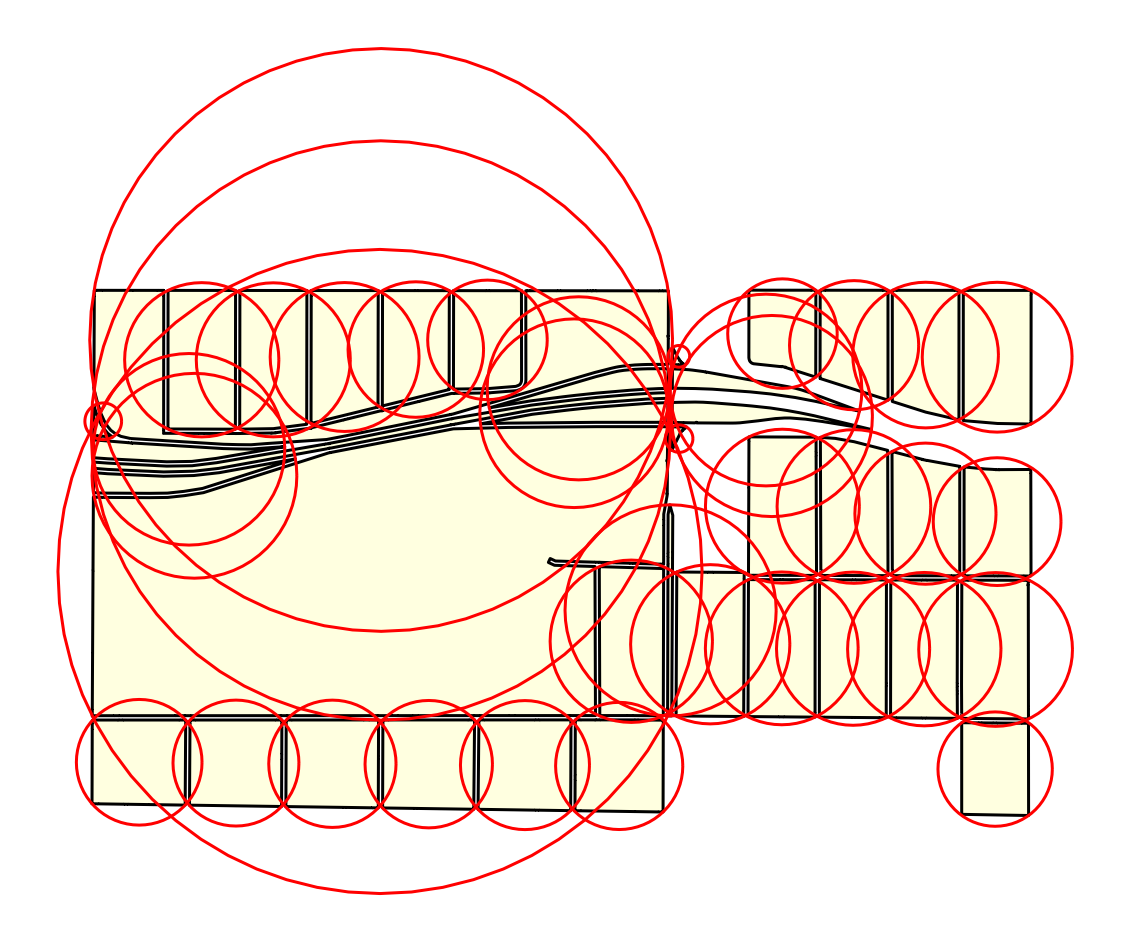

In [35]:
ax = urban_patch_gdf_prj.plot(figsize=(20, 20), edgecolor='k',linewidth=3, facecolor = "lightyellow")

mcc_gdf.plot(ax = ax, edgecolor='r',linewidth=3, facecolor = "None")
ax.set_axis_off()


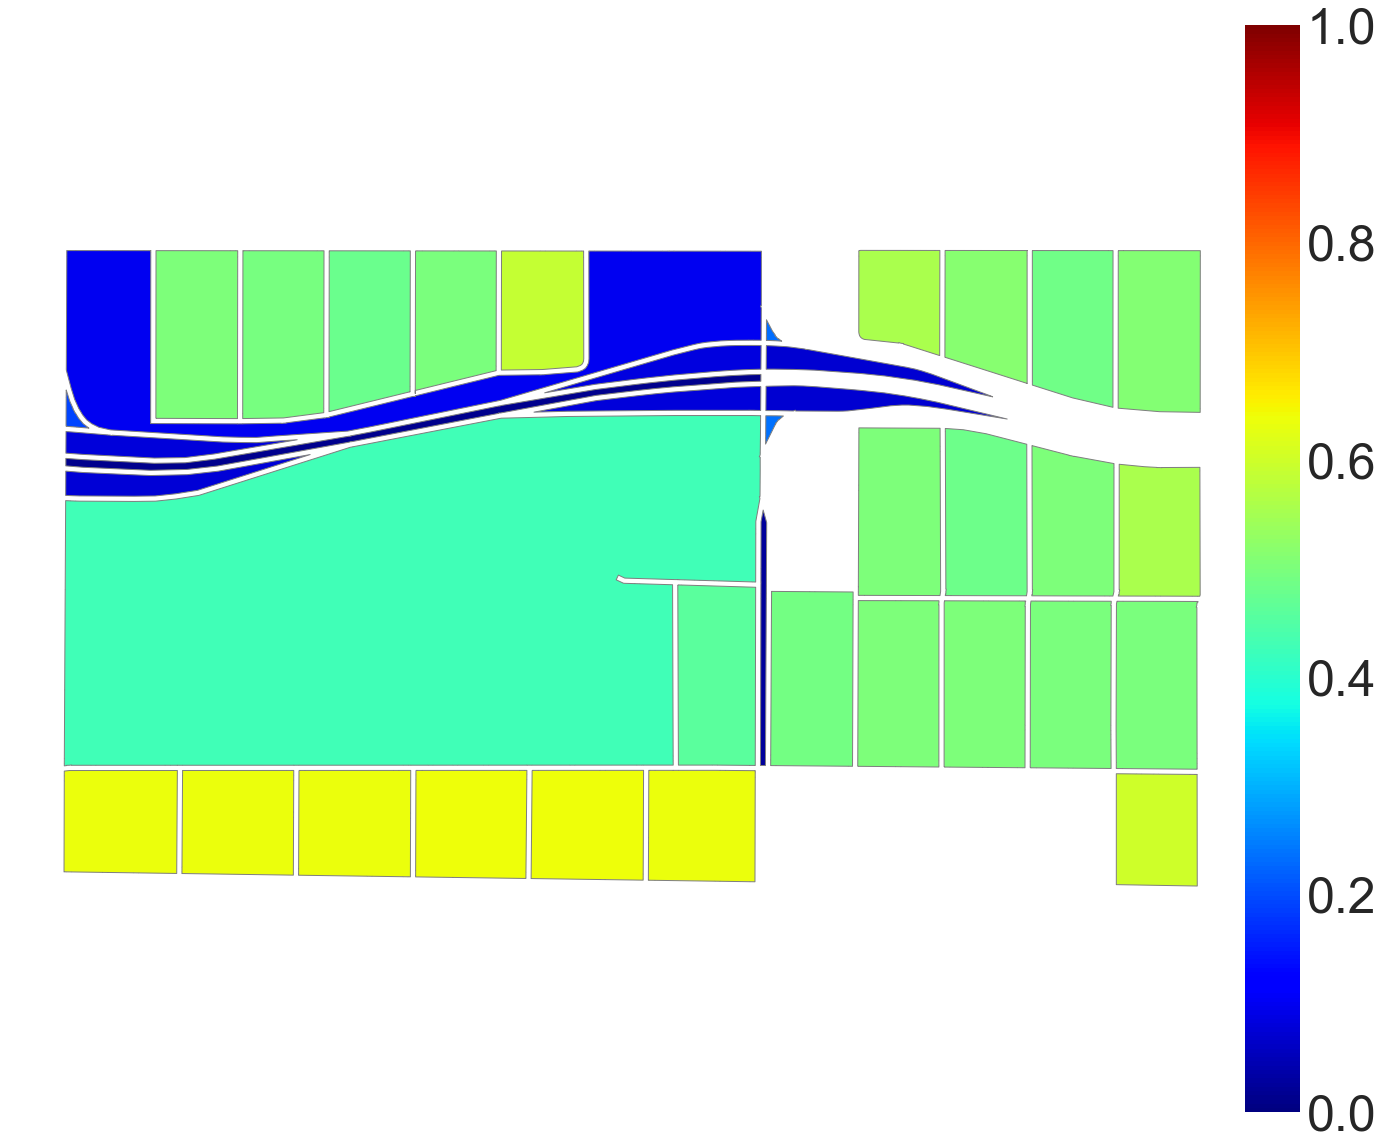

In [36]:
ax = urban_patch_gdf_prj.plot(figsize=(28,20), edgecolor='gray',linewidth=1, 
                                        column="shape_factor", cmap='jet',legend = True, vmin=0, vmax=1)

ax.set_axis_off()

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.5, 0.5))



In [37]:
urban_patch_gdf_prj.head(2)

,geometry,osmscID,UrbanPatch_area,UrbanPatch_perimeter,elevation,contains_Building,contains_Vegetation,contains_Waterbody,mrr_geometry,mrr_area,mcc_geometry,mcc_area,bearings,shape_factor
0,"POLYGON ((497040.429 4403575.532, 497040.940 4...",UrbanPatch_0,268117.620188,2442.500354,"[{'lat': 39.78029132732065, 'lon': -105.030373...","[Building_454546916, Building_367132590, Build...","[Vegetation_454547572, Vegetation_367131926, V...",[WaterBody_93548907],"POLYGON ((497838.035 4403772.352, 497038.895 4...",320416.668189,"POLYGON ((497885.675 4403571.241, 497883.523 4...",626630.361702,"[143, 270, 23, 90]",0.427872
1,"POLYGON ((497743.053 4403577.969, 497744.741 4...",UrbanPatch_1,18224.654767,588.552825,"[{'lat': 39.78029253283681, 'lon': -105.025351...","[Building_480545833, Building_480545831, Build...","[Vegetation_480650671, Vegetation_480657577, V...",[nan],"POLYGON ((497743.053 4403577.969, 497742.574 4...",18473.649799,"POLYGON ((497900.123 4403474.436, 497899.580 4...",39807.693339,"[90, 26, 269, 40]",0.457817


In [38]:
Patch_gdf = urban_patch_gdf_prj
l = []
for i in range(len(Patch_gdf)):
    for j in range(len(Patch_gdf.bearings[i])):
        l.append(Patch_gdf.bearings[i][j])
        
bearings = pd.Series(l)

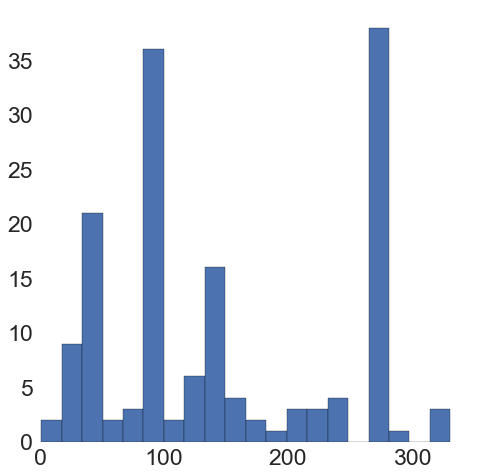

In [39]:
fig, ax = plt.subplots(figsize = (8,8))

# bearings.hist(ax = ax, bins=30)
plt.hist(bearings,bins = 20,edgecolor = "k",)
plt.tick_params(labelsize = 23)

ax.set_xlim(0, 360)
ax.set_facecolor('None')
ax.set_axis_on()


In [41]:
building_gdf_prj = oc.feature.add_shape_factor_attr(building_gdf_prj)

In [42]:
building_gdf_prj.head(2)

,osmid,geometry,tags,osmscID,Building_area,Building_perimeter,Building_height,Building_use,within_UrbanPatch,bearings,mcc_geometry,mcc_area,shape_factor
0,255324702,"POLYGON ((497681.062 4403722.222, 497681.132 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324702,2599.300448,466.833829,13.909091,Commercial,[UrbanPatch_0],"[102, 235, 324, 52]","POLYGON ((497813.091 4403712.981, 497812.752 4...",15524.359189,0.167434
1,255324705,"POLYGON ((497796.205 4403714.863, 497796.215 4...","{'addr:city': 'Denver', 'addr:housenumber': '4...",Building_255324705,472.878887,94.318348,18.000000,Commercial,[UrbanPatch_0],"[1, 89, 174, 269]","POLYGON ((497821.318 4403731.209, 497821.231 4...",1002.307523,0.471790


# interlayer attrs

In [43]:
urban_patch_gdf_prj = oc.feature.add_interlayer_vegetation_attr(urban_patch_gdf_prj,VG_gdf_prj)
urban_patch_gdf_prj = oc.feature.add_interlayer_waterbody_attr(urban_patch_gdf_prj,WG_gdf_prj)
urban_patch_gdf_prj = oc.feature.add_interlayer_building_attr(urban_patch_gdf_prj,building_gdf_prj)

In [44]:
max(list(urban_patch_gdf_prj["buildingDensity"])), min(list(urban_patch_gdf_prj["buildingDensity"]))

(0.25508730951109715, 0.0)

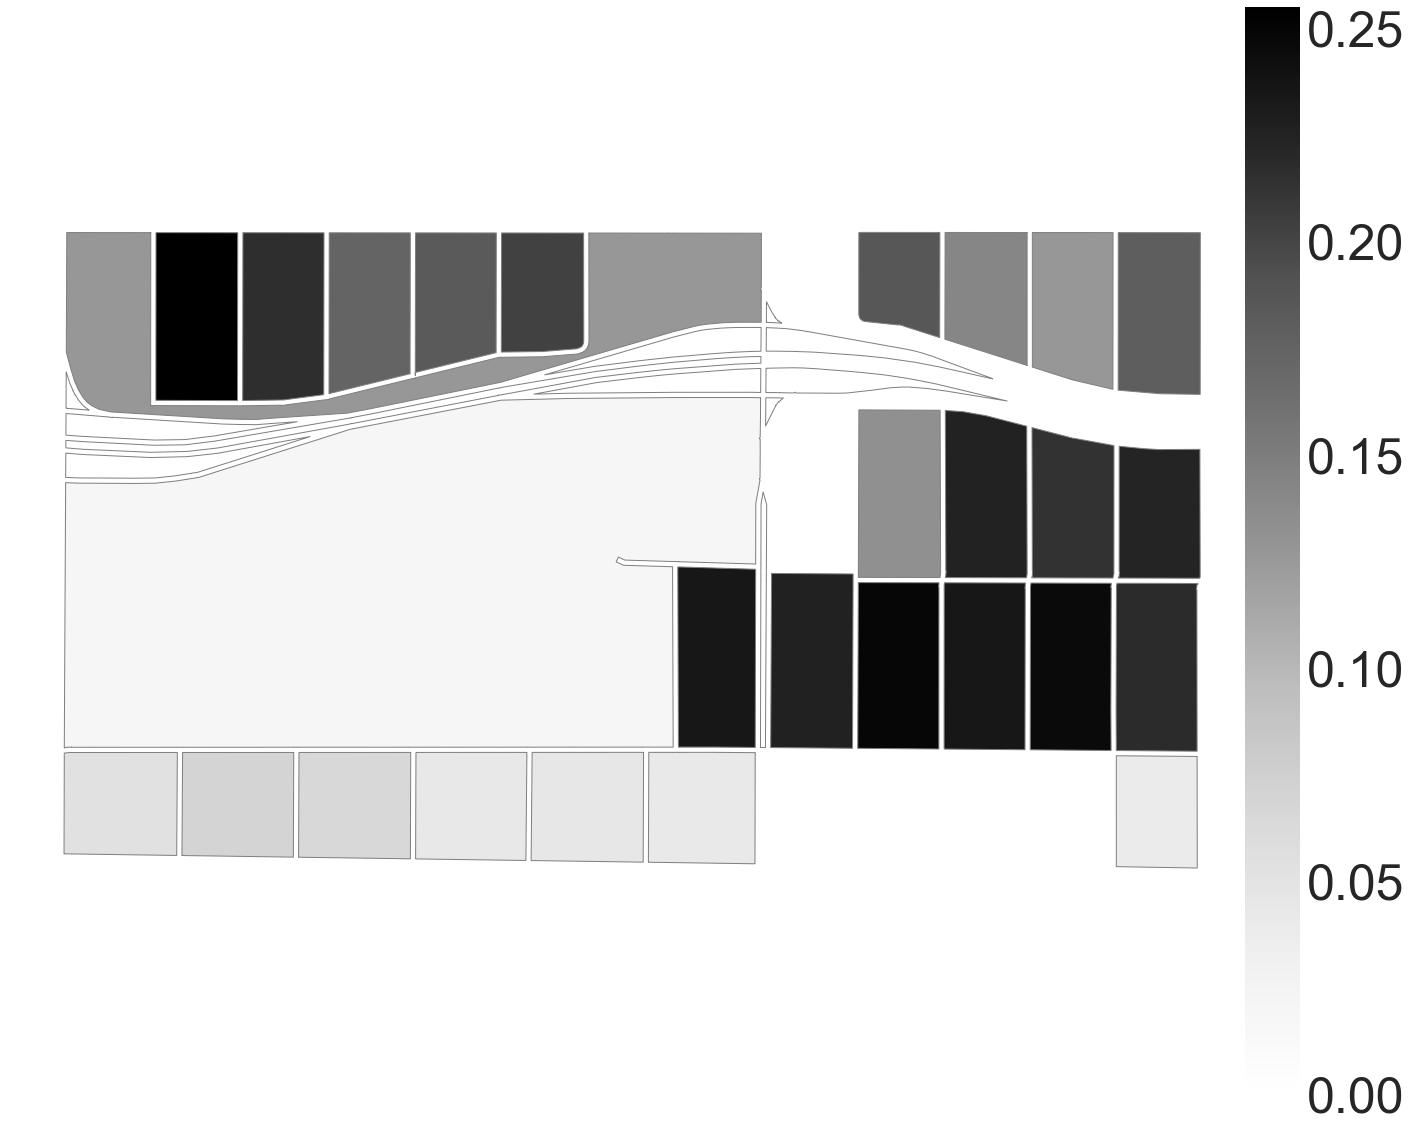

In [45]:
ax = urban_patch_gdf_prj.plot(figsize=(28,20), edgecolor='gray',linewidth=1, 
                                        column="buildingDensity", cmap='Greys',legend = True) # vmin=0, vmax=1
 
ax.set_axis_off()

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.5, 0.5))

# fig = ax.get_figure()
# fig.savefig("4_" + cityName + "_10_buildingDensity.png", dpi = 400)

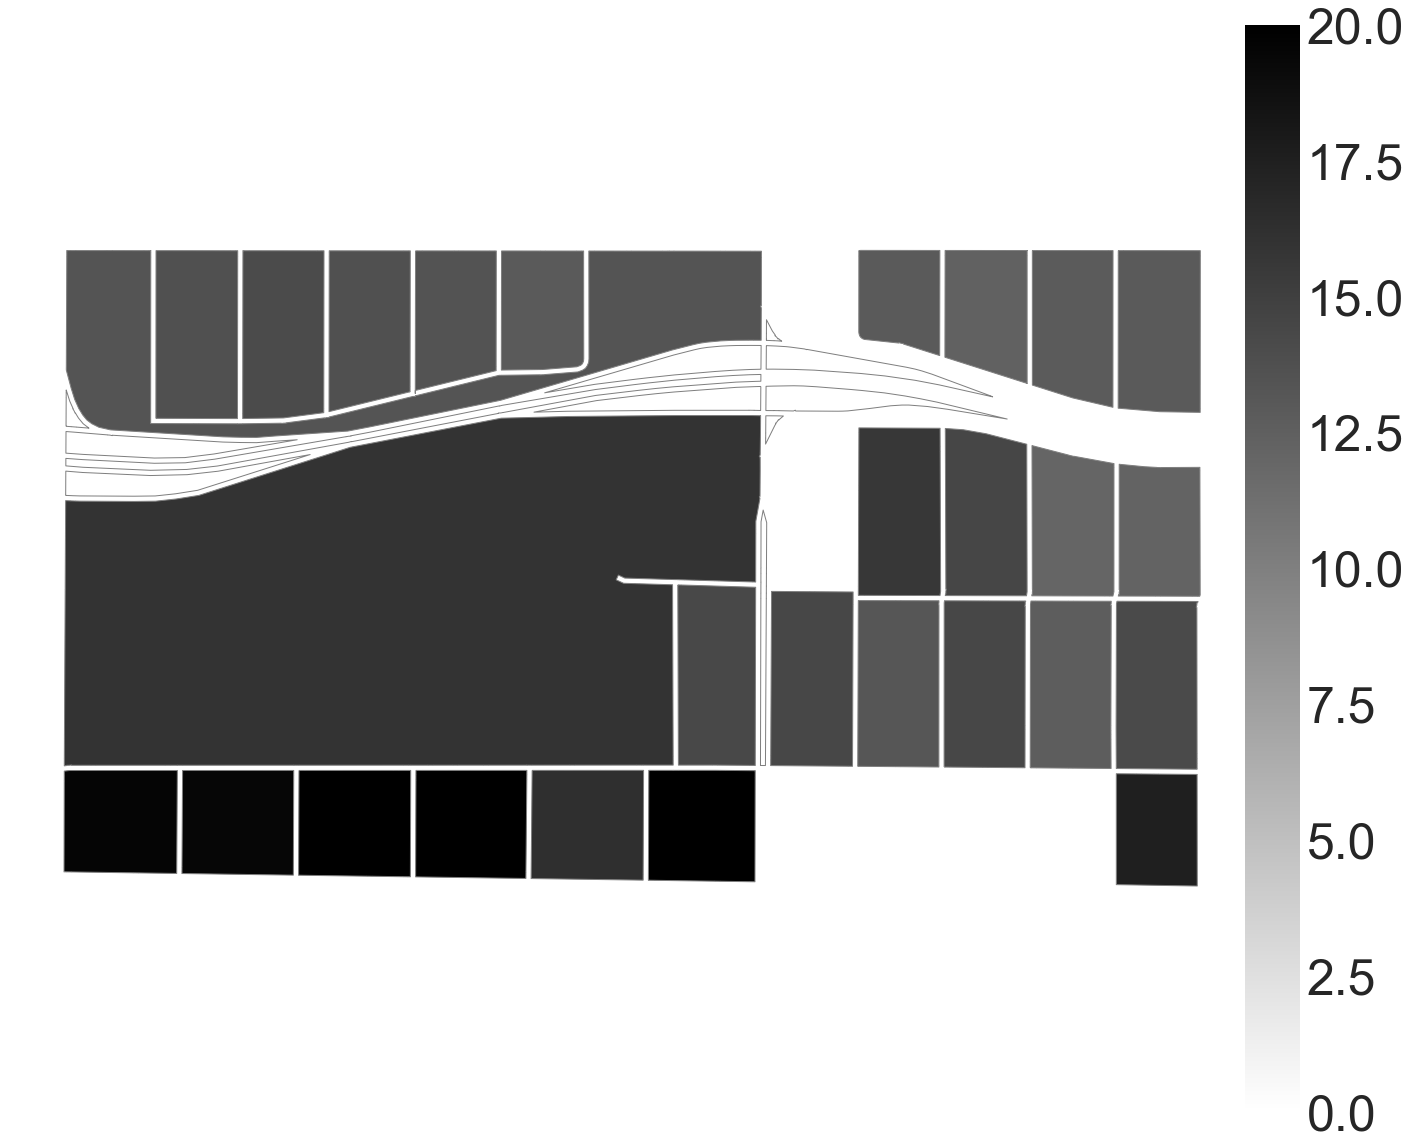

In [47]:
ax = urban_patch_gdf_prj.plot(figsize=(28,20), edgecolor='gray',linewidth=1, 
                                        column="avg_buildingHeight", cmap='binary',legend = True, vmin=0, vmax=20)

ax.set_axis_off()

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.5, 0.5))

# fig = ax.get_figure()
# fig.savefig("4_" + cityName + "_11_avg_buildingHeight.png", dpi = 400)

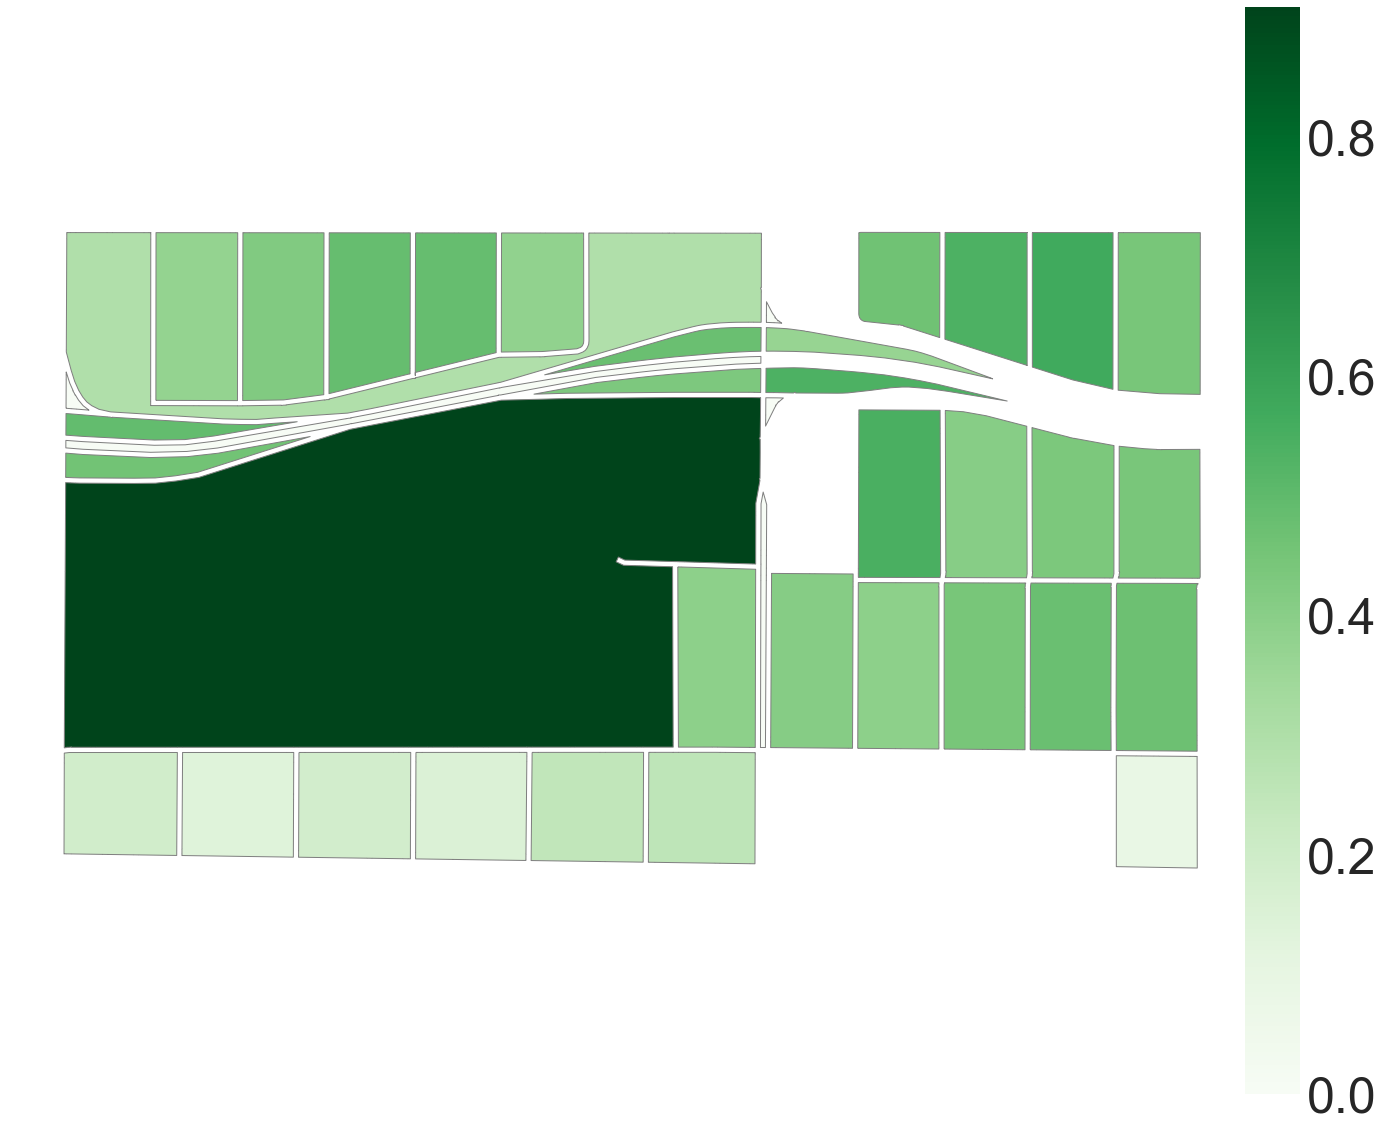

In [48]:
ax = urban_patch_gdf_prj.plot(figsize=(28,20), edgecolor='gray',linewidth=1, 
                                        column="vegetationDensity", cmap='Greens',legend = True) # vmin=0, vmax=1

ax.set_axis_off()

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.5, 0.5))


# fig = ax.get_figure()
# fig.savefig("4_" + cityName + "_12_vegetationDensity.png", dpi = 400)

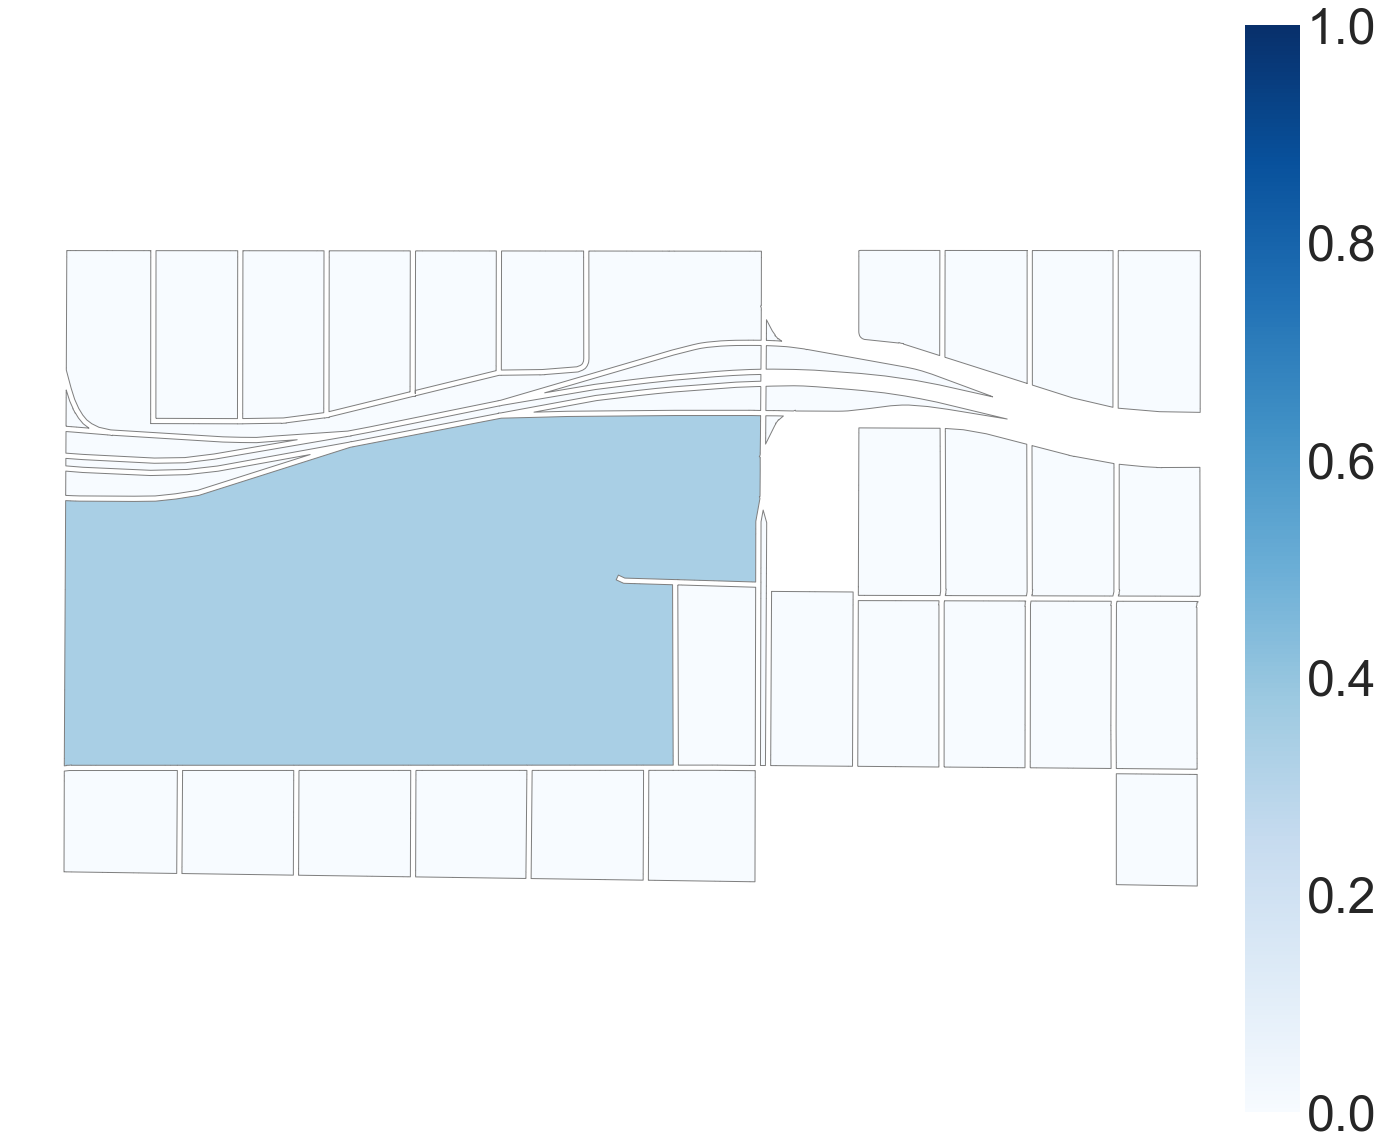

In [49]:
ax = urban_patch_gdf_prj.plot(figsize=(28,20), edgecolor='gray',linewidth=1, 
                                        column="waterbodyDensity", cmap='Blues',legend = True, vmin=0, vmax=1)

ax.set_axis_off()

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=50,)
cb_ax.set_anchor((-0.5, 0.5))


In [52]:
cj = oc.cityjson.city_json(building_gdf= building_gdf_prj, vegetation_gdf= VG_gdf_prj, waterbody_gdf = WG_gdf_prj,
              transportation_gdf= street_gdf_prj, urban_patch_gdf= urban_patch_gdf_prj)

In [53]:
cj.output_json( filename = "Denver_case_study")

Please wait a few minutes
-- Validating the syntax of the file
	(using the schemas 1.0.1)
-- Validating the internal consistency of the file (see docs for list)
	--Vertex indices coherent
	--Specific for CityGroups
	--Semantic arrays coherent with geometry
	--Root properties
	--Empty geometries
	--Duplicate vertices
	--Orphan vertices
	--CityGML attributes
